In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import random


In [3]:
path = Path('UTKFace')

In [4]:
def extract_age(filename):
    return float(filename.stem.split('_')[0])

In [5]:
def load_face_data(img_size, batch_size):
    tfms = get_transforms(max_warp=0.)
    return (ImageItemList.from_folder(path)
            .random_split_by_pct(0.1, seed=666)
            .label_from_func(extract_age)
            .transform(tfms, size=img_size)
            .databunch(bs=batch_size))

In [6]:
data = load_face_data(128, 256)

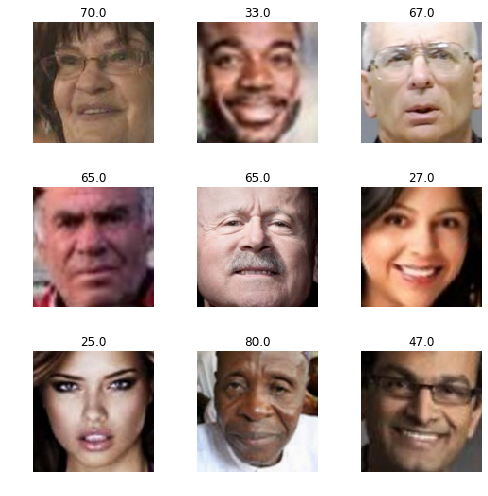

In [7]:
data.show_batch(rows=3, figsize=(7,7))

In [8]:
class AgeModel(nn.Module):
    def __init__(self):
        super().__init__()
        layers = list(models.resnet18(pretrained=True).children())[:-2]
        layers += [AdaptiveConcatPool2d(),Flatten()]
        layers += [nn.Linear(1024, 16), nn.ReLU(), nn.Linear(16,1)]
        self.agemodel = nn.Sequential(*layers)
    def forward(self, x):
        return self.agemodel(x).squeeze() # could add 116*torch.sigmoid 

In [9]:
model = AgeModel()

In [10]:
learn = Learner(data, model, loss_func = F.l1_loss)

In [14]:
learn.split([model.agemodel[2],model.agemodel[-3]])

In [15]:
learn.layer_groups[-1]

Sequential(
  (0): Linear(in_features=1024, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=1, bias=True)
)

In [16]:
learn.freeze_to(-1)

In [17]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss
1,16.753508,12.389215
2,11.318727,9.466236
3,9.710931,9.204001


In [18]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss
1,9.190080,8.783889
2,8.773420,8.562950
3,8.223539,7.802735
4,7.955016,7.657989
5,7.860390,7.619447


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


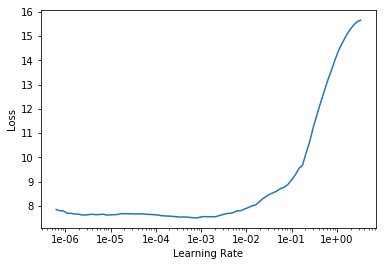

In [19]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [20]:
learn.fit_one_cycle(12, max_lr = slice(1e-4,1e-3))

epoch,train_loss,valid_loss
1,7.135162,6.688707
2,6.372702,5.961040
3,5.897716,5.836576
4,5.435044,6.328089
5,5.032613,5.024678
6,4.799635,4.993574
7,4.538699,5.662941
8,4.224709,5.004953
9,3.957267,4.586293
10,3.679125,4.549324


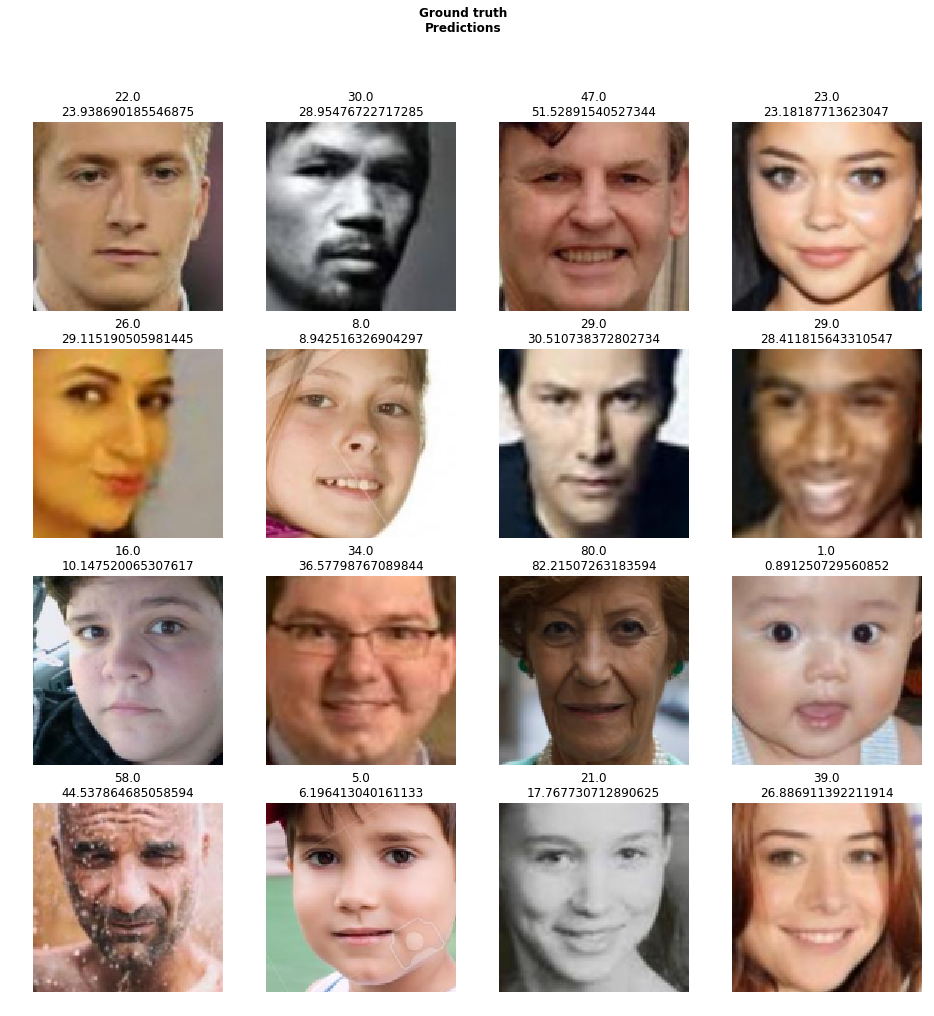

In [21]:
learn.show_results(rows=4)

In [22]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [256, 64, 64, 64]    9408       True      
______________________________________________________________________
BatchNorm2d          [256, 64, 64, 64]    128        True      
______________________________________________________________________
ReLU                 [256, 64, 64, 64]    0          False     
______________________________________________________________________
MaxPool2d            [256, 64, 32, 32]    0          False     
______________________________________________________________________
Conv2d               [256, 64, 32, 32]    36864      True      
______________________________________________________________________
BatchNorm2d          [256, 64, 32, 32]    128        True      
______________________________________________________________________
ReLU                 [256, 64, 32, 32]    0          False     
______________________________________________________________